In [1]:
import numpy as np
import pandas as pd
import os
import sys

from utils import select_ores_greedy
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
# %matplotlib inline

import pickle
import cv2
from scipy.stats import pearsonr

import importlib
# from classifiers import R_from_path
%config InlineBackend.figure_format = 'png' 

In [28]:
import requests
from bs4 import BeautifulSoup
from scipy.interpolate import interp1d, PchipInterpolator
import csv

In [2]:
with open('input_0219_0224_0225.pkl', 'rb') as f:
    input_all = pickle.load(f)
pixels = input_all[0]
data = input_all[1]

In [15]:
# Construct the URL for the element's data page
url = f"https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z{26:02d}.html"

# Fetch the page content
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')
pre_tag = soup.find('pre')

# Extract data lines
lines = pre_tag.text.strip().split('\n')
data_lines = []
for line in lines:
    if line.strip() and not line.startswith(('E', '---')):
        data_lines.append(line.strip())

In [17]:
# Parse the data into arrays
energies = []
mu_rho = []
for line in data_lines:
    parts = line.split()
    if len(parts) >= 2:
        try:
            energy = float(parts[0])
            mu = float(parts[1])
            energies.append(energy)
            mu_rho.append(mu)
        except ValueError:
            continue  # Skip lines that don't contain valid floats

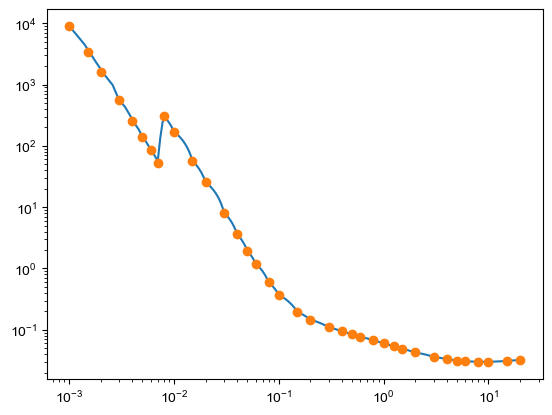

In [32]:
energies_keV = np.linspace(1e-3, 20, 50000)  
interpolator = interp1d(energies, mu_rho, kind='linear', bounds_error=False, fill_value="extrapolate")
mu_rho_values = interpolator(energies_keV)
plt.loglog(energies_keV, mu_rho_values)
plt.loglog(energies, mu_rho, 'o')

In [35]:
def fetch_mu_rho(element_symbol):
    """
    Fetches mass attenuation coefficients (μ/ρ) for a given element at specified energies.

    Parameters:
    - element_symbol: str, chemical symbol of the element (e.g., 'Fe')
    - energies_keV: list or array of energies in keV

    Returns:
    - mu_rho_values: list of μ/ρ values corresponding to the input energies
    """
    # Mapping of element symbols to atomic numbers
    symbol_to_atomic_number = {
        'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
        'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
        'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
        'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
        'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
        'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
        'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
        'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
        'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
        'Pa': 91, 'U': 92
    }

    atomic_number = symbol_to_atomic_number.get(element_symbol)
    if atomic_number is None:
        raise ValueError(f"Element symbol '{element_symbol}' is not recognized.")

    # Construct the URL for the element's data page
    url = f"https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z{atomic_number:02d}.html"

    # Fetch the page content
    response = requests.get(url)
    if response.status_code != 200:
        raise ConnectionError(f"Failed to retrieve data for {element_symbol} from NIST.")

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    pre_tag = soup.find('pre')
    if not pre_tag:
        raise ValueError(f"No data table found for {element_symbol}.")

    # Extract data lines
    lines = pre_tag.text.strip().split('\n')
    data_lines = []
    for line in lines:
        if line.strip() and not line.startswith(('E', '---')):
            data_lines.append(line.strip())

    # Parse the data into arrays
    energies = []
    mu_rho = []
    for line in data_lines:
        parts = line.split()
        if len(parts) >= 2:
            try:
                energy = float(parts[0])
                mu = float(parts[1])
                energies.append(energy)
                mu_rho.append(mu)
            except ValueError:
                continue  # Skip lines that don't contain valid floats

    # # Interpolate to get μ/ρ at desired energies
    # interpolator = interp1d(energies, mu_rho, kind='linear', bounds_error=False, fill_value="extrapolate")
    # mu_rho_values = interpolator(energies_keV)

    return energies, mu_rho


def save_mu_rho_to_csv(element_symbol, save_dir='nist_data'):
    """
    Fetch and save full μ/ρ vs energy data for an element to a local CSV file.
    """
    os.makedirs(save_dir, exist_ok=True)
    # 用 fetch_mu_rho 内部逻辑拉全表

    full_energies, mu_rho_values = fetch_mu_rho(element_symbol)

    filename = os.path.join(save_dir, f"{element_symbol}_mu_rho.csv")
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Energy_MeV', 'Mu_over_rho_cm2_per_g'])
        for e, mu in zip(full_energies, mu_rho_values):
            writer.writerow([e, mu])
    print(f"[+] Saved μ/ρ data for {element_symbol} to {filename}")


def get_mu_rho(element_symbol, energies_keV, data_dir='nist_data'):
    """
    Return μ/ρ values for an element at given energies.
    优先从本地读取，如无则爬取并保存，最终插值返回目标能量的μ/ρ。
    """
    filepath = os.path.join(data_dir, f"{element_symbol}_mu_rho.csv")
    if not os.path.exists(filepath):
        print(f"[i] μ/ρ data for {element_symbol} not found locally. Fetching from NIST...")
        save_mu_rho_to_csv(element_symbol, save_dir=data_dir)
    
    # 加载本地数据
    energies = []
    mu_rho = []
    with open(filepath, 'r') as f:
        next(f)  # skip header
        for line in f:
            e, mu = map(float, line.strip().split(','))
            energies.append(e)
            mu_rho.append(mu)

    interpolator = interp1d(energies, mu_rho, kind='linear', bounds_error=False, fill_value="extrapolate")
    return interpolator(energies_keV)



In [36]:
for elem in ['Fe', 'Zn', 'Pb', 'S', 'Si', 'O']:
    save_mu_rho_to_csv(elem)

[+] Saved μ/ρ data for Fe to nist_data/Fe_mu_rho.csv
[+] Saved μ/ρ data for Zn to nist_data/Zn_mu_rho.csv
[+] Saved μ/ρ data for Pb to nist_data/Pb_mu_rho.csv
[+] Saved μ/ρ data for S to nist_data/S_mu_rho.csv
[+] Saved μ/ρ data for Si to nist_data/Si_mu_rho.csv
[+] Saved μ/ρ data for O to nist_data/O_mu_rho.csv


In [43]:


def plot_mu_rho_vs_energy(element_symbol):
    """
    Plot mass attenuation coefficient (μ/ρ) vs photon energy for a given element.

    Parameters:
    - element_symbol: str, chemical symbol of the element (e.g., 'Fe')
    """
    energies_MeV = np.linspace(1e-3, 20, 10000)  
    mu_rho_values = get_mu_rho(element_symbol, energies_MeV)

    plt.figure(figsize=(8, 5))
    plt.loglog(energies_MeV*1e3, mu_rho_values, label=f'{element_symbol} (μ/ρ)', color='darkblue')
    plt.title(f'Mass Attenuation Coefficient of {element_symbol}', fontsize=14)
    plt.xlabel('Photon Energy (KeV)', fontsize=12)
    plt.ylabel(r'Mass Attenuation Coefficient $\mu/\rho$ (cm$^2$/g)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


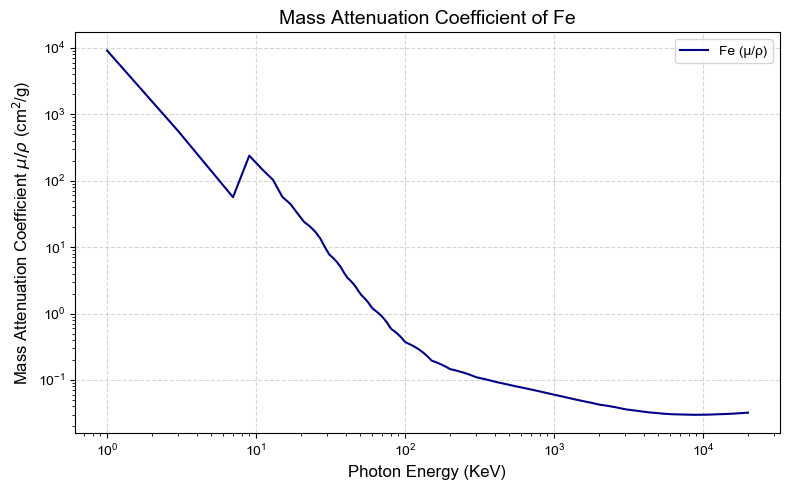

In [44]:
plot_mu_rho_vs_energy('Fe')